In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [267]:
def get_data_and_first_cleaning():
    rooth_path = '../rawdata/training/'
    failures_df = pd.read_csv(rooth_path + 'wind-farm-1-failures-training.csv')
    locations_df = pd.read_csv(rooth_path + "wind-farm-1-locations.csv")
    logs_df = pd.read_csv(rooth_path + 'wind-farm-1-logs-training.csv')
    metmast_df = pd.read_csv(rooth_path + 'wind-farm-1-metmast-training.csv', sep=';')
    signals_df = pd.read_csv(rooth_path + 'wind-farm-1-signals-training.csv', sep=';')
    power_df = pd.read_csv(rooth_path + 'Power_curve.csv', sep=',')
#     costs_df = pd.read_csv(rooth_path + 'HTW_Costs.csv')
    
    # pass all the Timestamps to date-time format
    failures_df['Timestamp'] = pd.to_datetime(failures_df['Timestamp'])
    logs_df['Timestamp'] = pd.to_datetime(logs_df['TimeDetected'])
    logs_df = logs_df.drop(columns=['TimeDetected','UnitTitleDestination'])
    metmast_df['Timestamp'] = pd.to_datetime(metmast_df['Timestamp'])
    signals_df['Timestamp'] = pd.to_datetime(signals_df['Timestamp'])
     
    # Drop Columns with std=0 by DA
    drop_features_metmast = ['Anemometer1_Offset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Min_Raindetection',
                             'Avg_Raindetection', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset',
                             'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 
                             'AirRessureSensorZeroOffset']
    metmast_df = metmast_df.drop(columns=drop_features_metmast)
    
    drop_features_signals = ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2']
    signals_df = signals_df.drop(columns=drop_features_signals)
    
    failures_df = failures_df.drop(columns='Remarks')
    
    #Fill na by interpolate
    signals_df = signals_df.bfill()
    
    return failures_df, locations_df, logs_df, metmast_df, signals_df, power_df

In [268]:
failures_df, locations_df, logs_df, metmast_df, signals_df, power_df = get_data_and_first_cleaning()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Classification label for failures
failures_generator = failures_df[failures_df['Component'] == 'GENERATOR']
failures_generator.replace('GENERATOR', 1, inplace=True)
failures_gen_bear = failures_df[failures_df['Component'] == 'GENERATOR_BEARING']
failures_gen_bear.replace('GENERATOR_BEARING', 1, inplace=True)
failures_hyd = failures_df[failures_df['Component'] == 'HYDRAULIC_GROUP']
failures_hyd.replace('HYDRAULIC_GROUP', 1, inplace=True)
failures_gearbox = failures_df[failures_df['Component'] == 'GEARBOX']
failures_gearbox.replace('GEARBOX', 1, inplace=True)
failures_transf = failures_df[failures_df['Component'] == 'TRANSFORMER']
failures_transf.replace('TRANSFORMER', 1, inplace=True)

In [ ]:
failures_generator

In [ ]:
# Merge DF Failures with DF of each component to know the moment of each failure
generator_final = signals_df.merge(failures_generator, on=['Timestamp','Turbine_ID'], how='outer')
gen_bear_final = signals_df.merge(failures_gen_bear, on=['Timestamp', 'Turbine_ID'], how='outer')
hyd_final = signals_df.merge(failures_hyd, on=['Timestamp', 'Turbine_ID'], how='outer')
gearbox_final = signals_df.merge(failures_gearbox, on=['Timestamp', 'Turbine_ID'], how='outer')
transf_final = signals_df.merge(failures_transf, on=['Timestamp', 'Turbine_ID'], how='outer')

In [ ]:
#Fill na on component column
generator_final['Component'].fillna(0, inplace=True)
gen_bear_final['Component'].fillna(0, inplace=True)
hyd_final['Component'].fillna(0, inplace=True)
gearbox_final['Component'].fillna(0, inplace=True)
transf_final['Component'].fillna(0, inplace=True)

In [ ]:
# Set Timestamp as Index
generator_final.set_index('Timestamp', inplace=True)
gen_bear_final.set_index('Timestamp', inplace=True)
hyd_final.set_index('Timestamp', inplace=True)
gearbox_final.set_index('Timestamp', inplace=True)
transf_final.set_index('Timestamp', inplace=True)

In [ ]:
# Sort Index
generator_final.sort_index(inplace=True)
gen_bear_final.sort_index(inplace=True)                                      
hyd_final.sort_index(inplace=True)
gearbox_final.sort_index(inplace=True)
transf_final.sort_index(inplace=True)

In [ ]:
# Reset Index to group by Timestamp and Turbine_ID
generator_final.reset_index(inplace=True)
gen_bear_final.reset_index(inplace=True)                                      
hyd_final.reset_index(inplace=True)
gearbox_final.reset_index(inplace=True)
transf_final.reset_index(inplace=True)

In [ ]:
def prepare_data(df, strategy='mean'):
    if strategy == 'mean':
        df = df.groupby(by=['Turbine_ID','Timestamp']).mean()
    else:
        df = df.grouby(by=['Turbine_ID', 'Timestamp']).max()
    
    # Fill na by interpolate
    df = df.bfill().reset_index()
        
    return df

In [ ]:
df_generator_final=prepare_data(generator_final)
df_gen_bear_final=prepare_data(gen_bear_final)
df_hyd_final=prepare_data(hyd_final)
df_gearbox_final=prepare_data(gearbox_final)
df_transf_final=prepare_data(transf_final)

In [ ]:
print(df_generator_final.isnull().values.any())
print(df_gen_bear_final.isnull().values.any())
print(df_hyd_final.isnull().values.any())
print(df_gearbox_final.isnull().values.any())
print(df_transf_final.isnull().values.any())

In [ ]:
def fill_na_by_turbine(df):
    turbines = ['T01', 'T06', 'T07', 'T09', 'T11']
    df_ = pd.DataFrame(columns=df.columns)
    for turbine in turbines:
        df1 = df.loc[df['Turbine_ID']==turbine]
        if df1['Component'].nunique()>1:
            index = df1[df1['Component']==1]
            index['date'] = index['Timestamp']
            index = index[['date','Timestamp', 'Turbine_ID']]
            df_merged = df1.merge(index, how='left', on=['Turbine_ID','Timestamp'])
            df_merged = df_merged.fillna(method='bfill')
            
            #If there is not a failure after, hold present date
            df_merged['date'] = df_merged['date'].fillna(df_merged['Timestamp'])
            
            df_merged['TTF'] = round((df_merged['date'] - 
                                      df_merged['Timestamp']) / np.timedelta64(1, 'D'),0)
        else:
            df_merged = df1
            df_merged['date'] = df_merged['Timestamp']
#             df1 = df1[['date','Timestamp', 'Turbine_ID']]
#             df_merged = df.merge(df1, how='left', on=['Turbine_ID','Timestamp'])
            
#             df_merged['date'] = df_merged['date'].fillna(df_merged['Timestamp'])
            df_merged['TTF'] = 0 # df_merged['date'] - df_merged['Timestamp'] 

        #Drop Column Date
        df_final = df_merged.drop(columns='date')

        #df_final['TTF'] = df_final['TTF'].dt.days

        df_ = pd.concat([df_, df_final])

    return df_

In [ ]:
generator_df = fill_na_by_turbine(df_generator_final)
gen_bear_df = fill_na_by_turbine(df_gen_bear_final)
hyd_df = fill_na_by_turbine(df_hyd_final)
gearbox_df = fill_na_by_turbine(df_gearbox_final)
transf_df = fill_na_by_turbine(df_transf_final)

In [ ]:
def Failure_Time_Horizon(days, period):
    if 2 <= days <= period:
        Flag=1
    else:
        Flag=0
    return Flag

In [ ]:
generator_df['60_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gen_bear_df['60_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
hyd_df['60_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gearbox_df['60_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
transf_df['60_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)

In [ ]:
generator_df['50_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 50),axis=1)
gen_bear_df['50_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 50),axis=1)
hyd_df['50_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 50),axis=1)
gearbox_df['50_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 50),axis=1)
transf_df['50_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 50),axis=1)

In [ ]:
generator_df['40_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
gen_bear_df['40_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
hyd_df['40_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
gearbox_df['40_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
transf_df['40_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)

In [ ]:
generator_df['30_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gen_bear_df['30_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
hyd_df['30_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gearbox_df['30_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
transf_df['30_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)

In [ ]:
generator_df['20_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
gen_bear_df['20_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
hyd_df['20_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
gearbox_df['20_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
transf_df['20_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)

In [ ]:
generator_df['10_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gen_bear_df['10_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
hyd_df['10_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gearbox_df['10_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
transf_df['10_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)

In [ ]:
## Save DF's to CSV
generator_df.to_csv('../rawdata/outro/generator_df.csv', index=False)
gen_bear_df.to_csv('../rawdata/outro/gen_bear_df.csv', index=False)
hyd_df.to_csv('../rawdata/outro/hyd_df.csv', index=False)
gearbox_df.to_csv('../rawdata/outro/gearbox_df.csv', index=False)
transf_df.to_csv('../rawdata/outro/transf_df.csv', index=False)

In [351]:
rooth_path = '../rawdata/outro/'
generator_df = pd.read_csv(rooth_path + 'generator_df.csv')
gen_bear_df = pd.read_csv(rooth_path + 'gen_bear_df.csv')
hyd_df = pd.read_csv(rooth_path + 'hyd_df.csv')
gearbox_df = pd.read_csv(rooth_path + 'gearbox_df.csv')
transf_df = pd.read_csv(rooth_path + 'transf_df.csv')

In [352]:
generator_df['Timestamp'] = pd.to_datetime(generator_df['Timestamp'])
gen_bear_df['Timestamp'] = pd.to_datetime(gen_bear_df['Timestamp'])
hyd_df['Timestamp'] = pd.to_datetime(hyd_df['Timestamp'])
gearbox_df['Timestamp'] = pd.to_datetime(gearbox_df['Timestamp'])
transf_df['Timestamp'] = pd.to_datetime(transf_df['Timestamp'])

In [353]:
features_drop = ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg','Gen_Phase3_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
                'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min','Grd_Prod_VoltPhse2_Avg',
                'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min', 'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg',
                'Spin_Temp_Avg', 'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg', 'Grd_Prod_CurPhse1_Avg', 'Prod_LatestAvg_TotActPwr',
                 'Grd_Prod_CurPhse3_Avg', 'Grd_Prod_Pwr_Max', 'Grd_Prod_Pwr_Min', 'HVTrafo_Phase1_Temp_Avg', 'Grd_Prod_CurPhse2_Avg',
                 'HVTrafo_Phase3_Temp_Avg', 'Grd_Prod_PsblePwr_Max', 'Grd_Prod_PsblePwr_Min', 'Grd_Prod_ReactPwr_Avg',
                'Grd_Prod_PsbleInd_Max', 'Grd_Prod_PsbleInd_Min', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_TotReactPwr',
                'Grd_Prod_PsbleInd_Avg', 'Blds_PitchAngle_Avg', 'Grd_Prod_ReactPwr_Max', 'Grd_Prod_ReactPwr_Min',
                'Nac_Direction_Avg', 'Amb_WindDir_Abs_Avg', 'Grd_Prod_PsbleCap_Min', 'Gear_Oil_Temp_Avg', 'Grd_Prod_VoltPhse1_Avg']

In [354]:
## Remove columns with strong correlations
generator_df = generator_df.drop(columns=features_drop)
gen_bear_df = gen_bear_df.drop(columns=features_drop)
hyd_df = hyd_df.drop(columns=features_drop)
gearbox_df = gearbox_df.drop(columns=features_drop)
transf_df = transf_df.drop(columns=features_drop)

In [355]:
generator_df.columns

Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Avg', 'Gen_RPM_Std',
       'Gen_Bear_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Hyd_Oil_Temp_Avg',
       'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Amb_WindSpeed_Max',
       'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std',
       'Amb_WindDir_Relative_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0',
       'Prod_LatestAvg_ReactPwrGen0', 'HVTrafo_Phase2_Temp_Avg',
       'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg',
       'Gen_SlipRing_Temp_Avg', 'Blds_PitchAngle_Std',
       'Cont_VCP_ChokcoilTemp_Avg', 'Grd_RtrInvPhase2_Temp_Avg',
       'Cont_VCP_WtrTemp_Avg', 'Grd_Prod_Pwr_Avg', 'Grd_Prod_CosPhi_Avg',
       'Grd_Prod_Freq_Avg', 'Grd_Prod_VoltPhse3_Avg', 'Grd_Busbar_Temp_Avg',
       'Grd_Prod_Pwr_Std', 'Grd_Prod_ReactPwr_Std', 'Grd_Prod_PsblePwr_Avg',
       'Grd_Prod_PsblePwr_Std', 'Grd_Prod_PsbleInd_Std',
       'Grd_Prod_PsbleCap_Avg', 'Grd_Prod_PsbleCap_Max',
       'Grd_Prod_PsbleCap_Std', 'Gen_Bear2_Temp_Avg', 'Componen

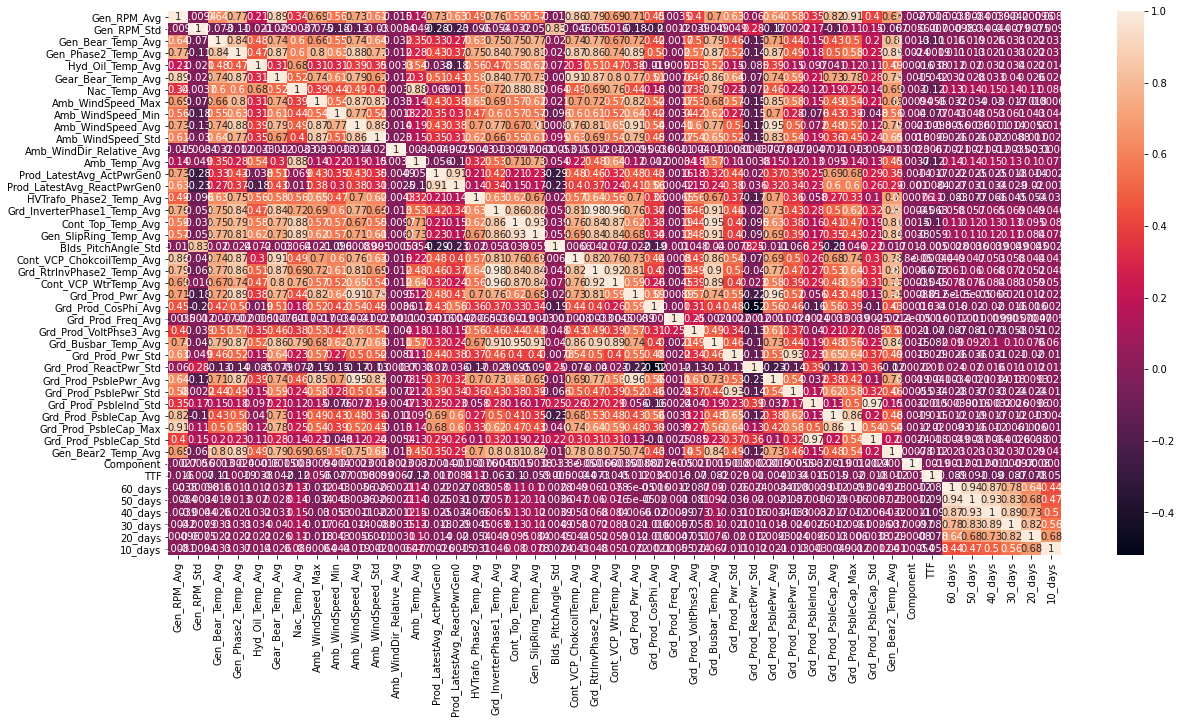

In [356]:
#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = generator_df.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [357]:
def prepare_train_test(df):
    last_date = df['Timestamp'].iloc[-1]
    split = last_date - pd.DateOffset(months=3)
    df_train = df[df['Timestamp'] < split]
    df_test = df[df['Timestamp'] >= split]
    
    return df_train, df_test

In [358]:
generator_df_train, generator_df_test = prepare_train_test(generator_df)
gen_bear_df_train, gen_bear_df_test = prepare_train_test(gen_bear_df)
hyd_df_train, hyd_df_test = prepare_train_test(hyd_df)
gearbox_df_train, gearbox_df_test = prepare_train_test(gearbox_df)
transf_df_train, transf_df_test = prepare_train_test(transf_df)

In [359]:
#Group by day per turbine
def group_per_frequency(df, strategy='mean'):
    df['Date'] = df['Timestamp'].dt.date
    if strategy == 'max':
        df = df.groupby(by=['Turbine_ID','Date']).max().reset_index().drop(columns='Timestamp')
    else:
        df = df.groupby(by=['Turbine_ID','Date']).mean().reset_index()
        
    return df

In [360]:
df_train_gearbox_day = group_per_frequency(gearbox_df_train)
df_train_gen_day = group_per_frequency(generator_df_train)
df_train_gen_bear_day = group_per_frequency(gen_bear_df_train)
df_train_hyd_day = group_per_frequency(hyd_df_train)
df_train_transf_day = group_per_frequency(transf_df_train)
df_test_gearbox_day = group_per_frequency(gearbox_df_test)
df_test_gen_day = group_per_frequency(generator_df_test)
df_test_gen_bear_day = group_per_frequency(gen_bear_df_test)
df_test_hyd_day = group_per_frequency(hyd_df_test)
df_test_transf_day = group_per_frequency(transf_df_test)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [361]:
df_train_hyd_day['30_days'] = np.ceil(df_train_hyd_day['30_days'])
df_test_hyd_day['30_days'] = np.ceil(df_test_hyd_day['30_days'])

In [362]:
def add_features(df_in, rolling_win_size):
    
    sensor_cols = []
    for i in df_in.keys()[2:-8]:
        sensor_cols.append(i)
    sensor_av_cols = [nm+'_av' for nm in sensor_cols]
    sensor_sd_cols = [nm+'_sd' for nm in sensor_cols]
    df_out = pd.DataFrame()
    ws = rolling_win_size
    #calculate rolling stats for each engine id
    for m_id in pd.unique(df_in.Turbine_ID):
        # get a subset for each engine sensors
        df_engine = df_in[df_in['Turbine_ID'] == m_id]
        df_sub = df_engine[sensor_cols]
        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
        # combine the two new subset dataframes columns to the engine subset
        new_ftrs = pd.concat([df_engine,av,sd], axis=1)
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out,new_ftrs])
    return df_out

In [363]:
df_train_hyd_extra = add_features(df_train_hyd_day, 25)
df_test_hyd_extra = add_features(df_test_hyd_day, 25)

In [364]:
# X_train, X_test = scale(df_out_2, df_out_test)
X_train = df_train_hyd_extra.drop(columns=['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID'])
X_test = df_test_hyd_extra.drop(columns=['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID'])

In [365]:
y_train = df_train_hyd_extra['30_days']
y_test = df_test_hyd_extra['30_days']

In [368]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn import metrics

In [369]:
my_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, random_state=42)
my_model.fit(X_train, y_train)
my_model.predict(X_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [391]:
temp = y_test.to_frame()

In [392]:
temp[temp['30_days'] == 1]

,30_days
141,1.0
142,1.0
143,1.0
144,1.0
145,1.0
146,1.0
147,1.0
148,1.0
149,1.0
150,1.0
